### Forcasting - Lebanon

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers


Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/conflict-clusters.csv')

In [4]:
data = df.loc[df['country'] == 'Lebanon', :]

In [6]:
data.shape

(2887, 58)

In [7]:
# Dropping columns not used in modeling
data.drop(columns=['year', 
                   'sub_event_type',
                   'actor1',
                   'assoc_actor_1',
                   'inter1',
                   'actor2',
                   'assoc_actor_2',
                   'inter2',
                   'interaction',
                   'region',
                   'admin2',
                   'admin3',
                   'location',
                   'timestamp',
                   'country',
                   'MA/CU'], inplace=True)

In [8]:
# Calculating weekly even count
df = (pd.to_datetime(data['event_date']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))

In [9]:
df.head()

,date,count
0,2019-11-13,77
1,2019-11-04,72
2,2019-11-05,67
3,2019-12-20,59
4,2019-11-12,58


In [10]:
data['event_date'] = pd.to_datetime(data['event_date'])

In [11]:
# merging Lebanon event counts and Lebanon events
data = pd.merge(data, df, left_on='event_date', right_on='date', how='outer')

In [13]:
data.set_index('event_date', inplace=True)

In [14]:
data.drop(columns='date', inplace=True)

In [15]:
# Dummying admin1 location
pd.get_dummies(data=data, 
               columns=['event_type',
                        'admin1'])

,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters,count,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians,admin1_Akkar,admin1_Baalbek-Hermel,admin1_Beirut,admin1_Bekaa,admin1_Mount Lebanon,admin1_Nabatiye,admin1_North,admin1_South
event_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,34.4719,36.0436,1,0,33,57,1,0.0,1507.9738,6.22,-0.82,-0.51,-1.00,-0.31,-0.58,-1.63,28,5,4,5,6,6,64.51,44,23,52,50,78.83,88.2,8.7,7.6,5.7,7.4,9.3,2.36,47.19,88.43,666.0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0
2017-01-05,33.5408,35.3767,1,0,35,59,1,0.0,1507.9738,6.22,-0.82,-0.51,-1.00,-0.31,-0.58,-1.63,28,5,4,5,6,6,64.51,44,23,52,50,78.83,88.2,8.7,7.6,5.7,7.4,9.3,2.36,47.19,88.43,666.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1
2017-01-11,33.5599,35.3756,1,0,42,59,1,0.0,1507.9738,6.22,-0.82,-0.51,-1.00,-0.31,-0.58,-1.63,28,5,4,5,6,6,64.51,44,23,52,50,78.83,88.2,8.7,7.6,5.7,7.4,9.3,2.36,47.19,88.43,666.0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1
2017-01-13,34.1794,36.4208,1,0,40,64,1,0.0,1507.9738,6.22,-0.82,-0.51,-1.00,-0.31,-0.58,-1.63,28,5,4,5,6,6,64.51,44,23,52,50,78.83,88.2,8.7,7.6,5.7,7.4,9.3,2.36,47.19,88.43,666.0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
2017-01-14,34.3942,36.3847,2,1,33,63,1,0.0,1507.9738,6.22,-0.82,-0.51,-1.00,-0.31,-0.58,-1.63,28,5,4,5,6,6,64.51,44,23,52,50,78.83,88.2,8.7,7.6,5.7,7.4,9.3,2.36,47.19,88.43,666.0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30,33.8919,35.4816,1,0,35,54,12,0.0,1511.0018,6.23,-0.79,-0.58,-1.06,-0.33,-0.54,-1.64,28,5,4,5,7,6,64.51,40,18,48,47,78.86,85.0,8.1,7.1,5.1,7.2,8.7,2.41,47.32,88.51,667.5,1,17,0,0,1,0,0,0,0,1,0,0,0,0,0
2019-12-30,34.4367,35.8497,1,0,35,54,12,0.0,1511.0018,6.23,-0.79,-0.58,-1.06,-0.33,-0.54,-1.64,28,5,4,5,7,6,64.51,40,18,48,47,78.86,85.0,8.1,7.1,5.1,7.2,8.7,2.41,47.32,88.51,667.5,1,17,0,0,1,0,0,0,0,0,0,0,0,1,0
2019-12-31,34.4367,35.8497,1,0,30,55,12,0.0,1511.0018,6.23,-0.79,-0.58,-1.06,-0.33,-0.54,-1.64,28,5,4,5,7,6,64.51,40,18,48,47,78.86,85.0,8.1,7.1,5.1,7.2,8.7,2.41,47.32,88.51,667.5,1,3,0,0,1,0,0,0,0,0,0,0,0,1,0


In [16]:
data.drop(columns=['event_type', 'admin1'], inplace=True)

In [17]:
y = data['count']
X = data.drop(columns=['count'])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [19]:
minmax = MinMaxScaler()

In [20]:
# Normalizing numeric data
X_train = minmax.fit_transform(X_train)
X_test = minmax.fit_transform(X_test)

In [21]:
X_train.shape

(2165, 39)

In [31]:
train = TimeseriesGenerator(X_train, y_train, length=3, batch_size=64)
test = TimeseriesGenerator(X_test, y_test, length=3, batch_size=64)

In [32]:
batch_x, batch_y = train[0]

In [33]:
batch_x.shape

(64, 3, 39)

In [37]:
# The LSTM design
model = Sequential()
# First LSTM layer with Dropout 
model.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l1(1e-5),return_sequences=True, input_shape=(3, 39)))
model.add(Dropout(0.7))
# Second LSTM layer
model.add(LSTM(units=64, activation='relu', kernel_regularizer=regularizers.l1(1e-5),return_sequences=True))
model.add(Dropout(0.7))
# Third LSTM layer
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.7))
# The output layer

model.add(Flatten())
model.add(Dense(1))

# Compiling the RNN
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 3, 64)             26624     
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 192)              

In [38]:
# Fitting to the training set
hist = model.fit_generator(train, validation_data=(test), epochs=50)

Epoch 1/50
34/34 [==============================] - 2s 46ms/step - loss: 94.8766 - val_loss: 97.2984
Epoch 2/50
34/34 [==============================] - 0s 7ms/step - loss: 81.2558 - val_loss: 95.5004
Epoch 3/50
34/34 [==============================] - 0s 7ms/step - loss: 78.6232 - val_loss: 94.5141
Epoch 4/50
34/34 [==============================] - 0s 8ms/step - loss: 78.9318 - val_loss: 94.3508
Epoch 5/50
34/34 [==============================] - 0s 8ms/step - loss: 78.8646 - val_loss: 92.5734
Epoch 6/50
34/34 [==============================] - 0s 7ms/step - loss: 78.0010 - val_loss: 92.5455
Epoch 7/50
34/34 [==============================] - 0s 7ms/step - loss: 77.7191 - val_loss: 91.6989
Epoch 8/50
34/34 [==============================] - 0s 8ms/step - loss: 78.0909 - val_loss: 90.2060
Epoch 9/50
34/34 [==============================] - 0s 7ms/step - loss: 77.0955 - val_loss: 90.0199
Epoch 10/50
34/34 [==============================] - 0s 7ms/step - loss: 77.3178 - val_loss: 90.399

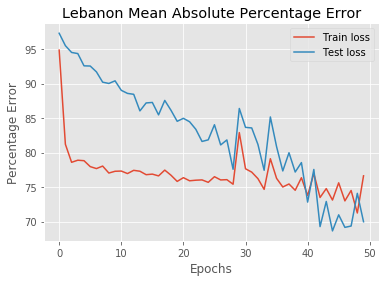

In [51]:
plt.style.use('ggplot')
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.title('Lebanon Mean Absolute Percentage Error')
plt.xlabel('Epochs')
plt.ylabel('Percentage Error')
plt.legend()
plt.savefig('imgs/lebanonloss.jpeg');

In [40]:
lebanon_preds = model.predict(test)

In [48]:
plt.style.use('ggplot')
def plot_predictions(test,predicted):
    plt.plot(test, label='True Values')
    plt.plot(predicted, label='Predicted Values')
    plt.title('Lebanon Forecast')
    plt.xlabel('Time')
    plt.ylabel('Weekly Count of Events')
    plt.legend()
    plt.savefig('imgs/lebanonforecast.jpeg');

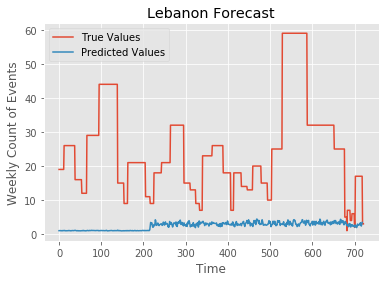

In [49]:
plot_predictions(y_test.values, lebanon_preds)